# Sistema Clasificador BETO Fine-Tuned para Análisis Retórico en Frases Políticas (Ad-hominem, Framing, Lógica y Retórica Vacía)  V2.0

In [ ]:
# Instalación de dependencias (si es necesario , si estás ejecutando el notebook en Google Colab o en Jupyter Notebook sin entorno virtual configurado)
!pip install transformers datasets scikit-learn evaluate -q
!pip install ipywidgets --upgrade
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
!pip install seaborn
!pip install matplotlib
!pip uninstall -y numpy
pip install numpy==1.24.4

### 1 PREPARO ENTONRO PARA GPU Y PYTORCH / TRANSFORMER  Importamos librerias 

In [1]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import evaluate

1. Carga el CSV con tus datos políticos
2. Detecta y elimina columnas duplicadas
3. Renombra columnas si es necesario
4. Se asegura de tener solo las columnas necesarias
5. Divide el dataset en entrenamiento y prueba
6. Convierte a objetos Dataset de HuggingFace
7. Mensaje de confirmación

### 2 Trabajamos el DATASET

In [5]:
# Leer dataset
df = pd.read_csv('../dataset/corpus_politico_codificado.csv')

# Mostrar columnas originales
print("Columnas originales:", df.columns.tolist())

# Eliminar duplicadas por nombre
df = df.loc[:, ~df.columns.duplicated()]

# Renombrar solo si es necesario
if 'texto' in df.columns and 'text' not in df.columns:
    df.rename(columns={'texto': 'text'}, inplace=True)
if 'etiqueta' in df.columns and 'label' not in df.columns:
    df.rename(columns={'etiqueta': 'label'}, inplace=True)

# Confirmar columnas finales
print("Columnas después de limpieza:", df.columns.tolist())

# Dejar solo columnas necesarias
df = df[['text', 'label']]

# Separar datos
train_texts, test_texts = train_test_split(df, test_size=0.2, random_state=42)

# Crear datasets para entrenamiento
train_dataset = Dataset.from_pandas(train_texts.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_texts.reset_index(drop=True))

print("✅ Dataset cargado correctamente.")


Columnas originales: ['texto', 'etiqueta', 'label']
Columnas después de limpieza: ['text', 'etiqueta', 'label']
✅ Dataset cargado correctamente.


### 3 Tokenizacion y Carga de modelo de clasificacion

In [7]:
#Use el modelo BETO, una versión de BERT entrenada para español.
model_name = 'dccuchile/bert-base-spanish-wwm-cased'
#Aca no estás entrenando nada todavía. Estás descargando los pesos preentrenados del modelo base BETO desde Hugging Face una sola vez.
tokenizer = AutoTokenizer.from_pretrained(model_name)

#Define una función para tokenizar los textos del dataset, rellenando o truncando para que tengan el mismo largo (requisito de BERT).
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

#Carga el modelo BETO y lo ajusta a tu tarea de clasificación de texto en 3 clases (num_labels=3)
"Añade el parámetro use_safetensors=True para evitar el error de vulnerabilidad de torch.load() que viste antes."
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=4,
    ignore_mismatched_sizes=True,
    #use_safetensors=True  # 👈 esto es la clave
)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4 Definición de función de evaluación con métrica de accuracy

In [8]:
#carga la métrica de evaluación “accuracy” desde la librería evaluate.
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### 5  HIPERPARAMETROS Configuración de entrenamiento para BETO

In [9]:
# Configuración de hiperparámetros de entrenamiento para BETO
training_args = TrainingArguments(
    output_dir="./results_beto",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    #learning_rate=2e-5,
    learning_rate=3e-5,
    #per_device_train_batch_size=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    #num_train_epochs=3,
    num_train_epochs=5,
    #weight_decay=0.01,
    weight_decay=0.005,
    logging_dir="./logs",
    load_best_model_at_end=True,
    logging_steps=10,
    save_total_limit=2,
)

In [5]:
import transformers
print(transformers.__file__)
import sys
print(sys.executable)
import transformers
print(transformers.__version__)


d:\_ JCAM 2010-2027\_3_MASTERAI_UNI\Ciclo3\3Proyecto_Invest1\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\transformers\__init__.py
d:\_ JCAM 2010-2027\_3_MASTERAI_UNI\Ciclo3\3Proyecto_Invest1\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\Scripts\python.exe
4.35.2


In [ ]:
!pip uninstall -y transformers
!pip install transformers==4.35.2

In [ ]:
pip install accelerate -U
pip install accelerate==0.25.0

# Entrennando a BETITO con Trainer (fine-tuning local en GPU)

In [10]:
import numpy as np
import torch
print("NumPy version:", np.__version__)
print("randperm to numpy works:", torch.randperm(5).numpy())
print(df['label'].unique())  # Revisa cuántas clases tienes realmente

NumPy version: 1.24.4
randperm to numpy works: [1 4 2 3 0]
[2 1 3 0]


In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

trainer.train()


  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 0.7884, 'learning_rate': 2.94e-05, 'epoch': 0.1}
{'loss': 0.0978, 'learning_rate': 2.88e-05, 'epoch': 0.2}
{'loss': 0.0175, 'learning_rate': 2.8199999999999998e-05, 'epoch': 0.3}
{'loss': 0.0072, 'learning_rate': 2.7600000000000003e-05, 'epoch': 0.4}
{'loss': 0.0046, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.5}
{'loss': 0.0034, 'learning_rate': 2.64e-05, 'epoch': 0.6}
{'loss': 0.0029, 'learning_rate': 2.58e-05, 'epoch': 0.7}
{'loss': 0.0026, 'learning_rate': 2.52e-05, 'epoch': 0.8}
{'loss': 0.0022, 'learning_rate': 2.4599999999999998e-05, 'epoch': 0.9}
{'loss': 0.002, 'learning_rate': 2.4e-05, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.001330263796262443, 'eval_accuracy': 1.0, 'eval_runtime': 4.4355, 'eval_samples_per_second': 45.09, 'eval_steps_per_second': 5.636, 'epoch': 1.0}
{'loss': 0.002, 'learning_rate': 2.3400000000000003e-05, 'epoch': 1.1}
{'loss': 0.0017, 'learning_rate': 2.2800000000000002e-05, 'epoch': 1.2}
{'loss': 0.0017, 'learning_rate': 2.22e-05, 'epoch': 1.3}
{'loss': 0.0016, 'learning_rate': 2.16e-05, 'epoch': 1.4}
{'loss': 0.0014, 'learning_rate': 2.1e-05, 'epoch': 1.5}
{'loss': 0.0013, 'learning_rate': 2.04e-05, 'epoch': 1.6}
{'loss': 0.0013, 'learning_rate': 1.98e-05, 'epoch': 1.7}
{'loss': 0.0012, 'learning_rate': 1.9200000000000003e-05, 'epoch': 1.8}
{'loss': 0.0012, 'learning_rate': 1.86e-05, 'epoch': 1.9}
{'loss': 0.0011, 'learning_rate': 1.8e-05, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.0007326291524805129, 'eval_accuracy': 1.0, 'eval_runtime': 4.3797, 'eval_samples_per_second': 45.665, 'eval_steps_per_second': 5.708, 'epoch': 2.0}
{'loss': 0.0011, 'learning_rate': 1.74e-05, 'epoch': 2.1}
{'loss': 0.001, 'learning_rate': 1.6800000000000002e-05, 'epoch': 2.2}
{'loss': 0.0009, 'learning_rate': 1.62e-05, 'epoch': 2.3}
{'loss': 0.0009, 'learning_rate': 1.56e-05, 'epoch': 2.4}
{'loss': 0.0009, 'learning_rate': 1.5e-05, 'epoch': 2.5}
{'loss': 0.0009, 'learning_rate': 1.44e-05, 'epoch': 2.6}
{'loss': 0.0009, 'learning_rate': 1.3800000000000002e-05, 'epoch': 2.7}
{'loss': 0.0009, 'learning_rate': 1.32e-05, 'epoch': 2.8}
{'loss': 0.0008, 'learning_rate': 1.26e-05, 'epoch': 2.9}
{'loss': 0.0008, 'learning_rate': 1.2e-05, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.0005324379308149219, 'eval_accuracy': 1.0, 'eval_runtime': 4.3095, 'eval_samples_per_second': 46.409, 'eval_steps_per_second': 5.801, 'epoch': 3.0}
{'loss': 0.0008, 'learning_rate': 1.1400000000000001e-05, 'epoch': 3.1}
{'loss': 0.0008, 'learning_rate': 1.08e-05, 'epoch': 3.2}
{'loss': 0.0007, 'learning_rate': 1.02e-05, 'epoch': 3.3}
{'loss': 0.0007, 'learning_rate': 9.600000000000001e-06, 'epoch': 3.4}
{'loss': 0.0007, 'learning_rate': 9e-06, 'epoch': 3.5}
{'loss': 0.0007, 'learning_rate': 8.400000000000001e-06, 'epoch': 3.6}
{'loss': 0.0007, 'learning_rate': 7.8e-06, 'epoch': 3.7}
{'loss': 0.0007, 'learning_rate': 7.2e-06, 'epoch': 3.8}
{'loss': 0.0007, 'learning_rate': 6.6e-06, 'epoch': 3.9}
{'loss': 0.0007, 'learning_rate': 6e-06, 'epoch': 4.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.0004470926651265472, 'eval_accuracy': 1.0, 'eval_runtime': 4.3199, 'eval_samples_per_second': 46.298, 'eval_steps_per_second': 5.787, 'epoch': 4.0}
{'loss': 0.0007, 'learning_rate': 5.4e-06, 'epoch': 4.1}
{'loss': 0.0007, 'learning_rate': 4.800000000000001e-06, 'epoch': 4.2}
{'loss': 0.0006, 'learning_rate': 4.2000000000000004e-06, 'epoch': 4.3}
{'loss': 0.0006, 'learning_rate': 3.6e-06, 'epoch': 4.4}
{'loss': 0.0006, 'learning_rate': 3e-06, 'epoch': 4.5}
{'loss': 0.0006, 'learning_rate': 2.4000000000000003e-06, 'epoch': 4.6}
{'loss': 0.0006, 'learning_rate': 1.8e-06, 'epoch': 4.7}
{'loss': 0.0006, 'learning_rate': 1.2000000000000002e-06, 'epoch': 4.8}
{'loss': 0.0006, 'learning_rate': 6.000000000000001e-07, 'epoch': 4.9}
{'loss': 0.0006, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.00042154290713369846, 'eval_accuracy': 1.0, 'eval_runtime': 4.2868, 'eval_samples_per_second': 46.655, 'eval_steps_per_second': 5.832, 'epoch': 5.0}
{'train_runtime': 352.83, 'train_samples_per_second': 11.337, 'train_steps_per_second': 1.417, 'train_loss': 0.019314164231531324, 'epoch': 5.0}


TrainOutput(global_step=500, training_loss=0.019314164231531324, metrics={'train_runtime': 352.83, 'train_samples_per_second': 11.337, 'train_steps_per_second': 1.417, 'train_loss': 0.019314164231531324, 'epoch': 5.0})

# Guardando el modelo

In [12]:
model.save_pretrained("./modelo_beto_gpu")
tokenizer.save_pretrained("./modelo_beto_gpu")

('./modelo_beto_gpu\\tokenizer_config.json',
 './modelo_beto_gpu\\special_tokens_map.json',
 './modelo_beto_gpu\\vocab.txt',
 './modelo_beto_gpu\\added_tokens.json',
 './modelo_beto_gpu\\tokenizer.json')

# Analisis y Metricas

  0%|          | 0/25 [00:00<?, ?it/s]

                 precision    recall  f1-score   support

     ad_hominem       1.00      1.00      1.00        58
framing_binario       1.00      1.00      1.00        42
          logos       1.00      1.00      1.00        49
 retorica_vacia       1.00      1.00      1.00        51

       accuracy                           1.00       200
      macro avg       1.00      1.00      1.00       200
   weighted avg       1.00      1.00      1.00       200



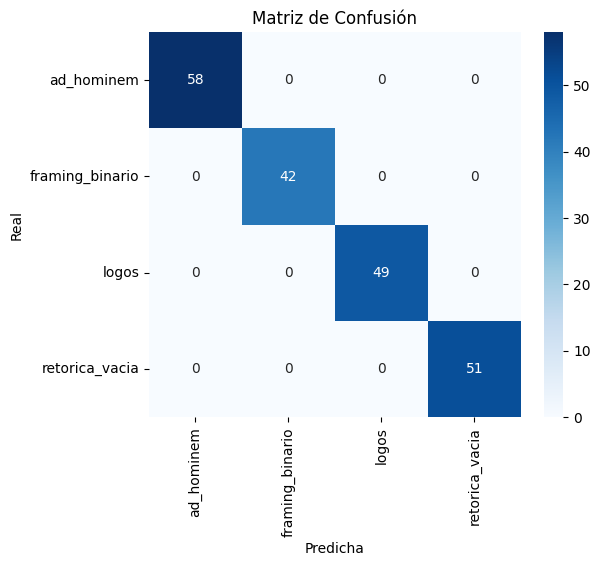

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las predicciones del modelo
predictions = trainer.predict(tokenized_test)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Etiquetas de clase (ajústalas si las tuyas son distintas)
#labels = ["Populista", "Vacío", "Técnico", "Emocional"]
labels = ["ad_hominem", "framing_binario", "logos", "retorica_vacia"]

# Imprimir reporte detallado
print(classification_report(y_true, y_pred, target_names=labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel('Predicha')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


LOSS :
Gráfico de pérdida (loss) por epoch /
Gráfico de accuracy por epoch

d:\_ JCAM 2010-2027\_3_MASTERAI_UNI\Ciclo3\3Proyecto_Invest1\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


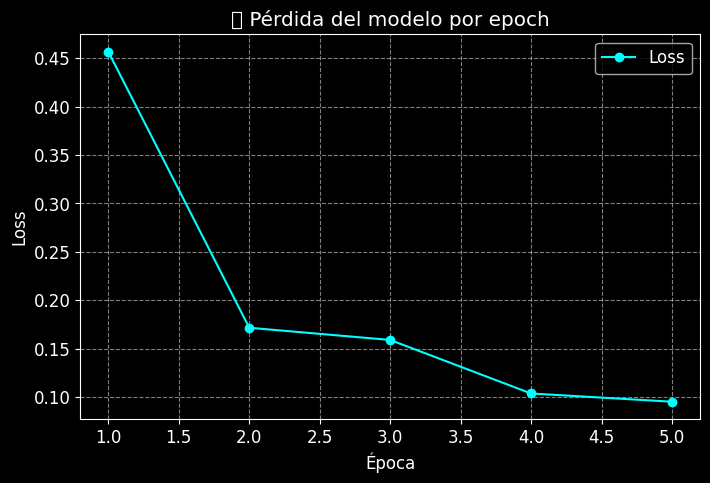

d:\_ JCAM 2010-2027\_3_MASTERAI_UNI\Ciclo3\3Proyecto_Invest1\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


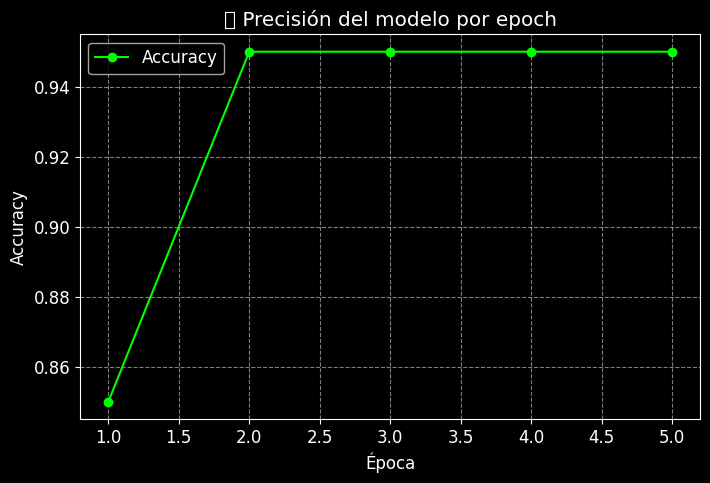

In [32]:
import matplotlib.pyplot as plt

# Simulamos el log history (esto lo genera el trainer automáticamente si no lo modificaste)
log_history = trainer.state.log_history

# Filtrar para quedarnos con evaluaciones por epoch
eval_logs = [entry for entry in log_history if 'eval_loss' in entry]

# Extraer datos
epochs = [entry['epoch'] for entry in eval_logs]
eval_loss = [entry['eval_loss'] for entry in eval_logs]
eval_accuracy = [entry['eval_accuracy'] for entry in eval_logs]

# Estilo más dark
plt.style.use('dark_background')
plt.rcParams['font.size'] = 12

# Plot de pérdida
plt.figure(figsize=(8, 5))
plt.plot(epochs, eval_loss, marker='o', color='cyan', label='Loss')
plt.title("📉 Pérdida del modelo por epoch")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# Plot de accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, eval_accuracy, marker='o', color='lime', label='Accuracy')
plt.title("🎯 Precisión del modelo por epoch")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


ACCURACY : Este gráfico te permitirá ver cómo fue mejorando el rendimiento del modelo en cada evaluación:

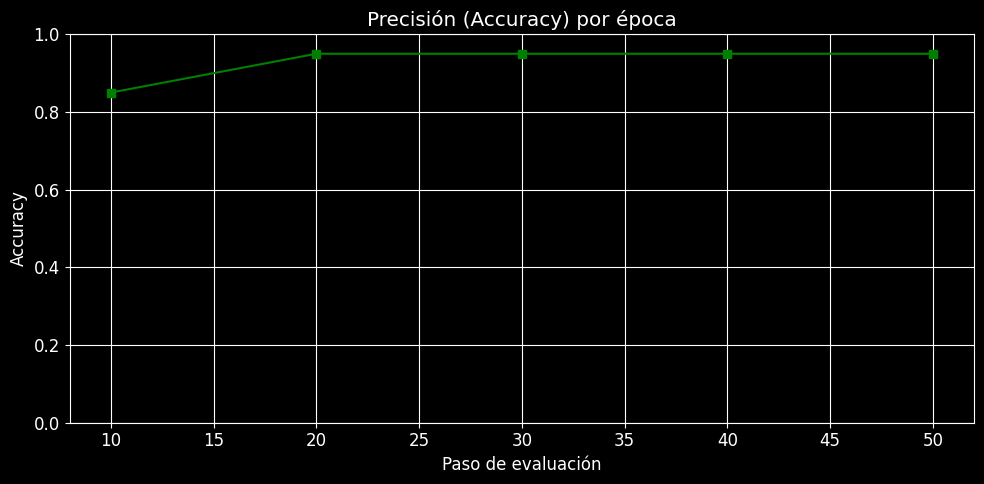

In [36]:
import matplotlib.pyplot as plt

# Extraemos los pasos y el accuracy del log
eval_steps = [entry["step"] for entry in trainer.state.log_history if "eval_accuracy" in entry]
accuracies = [entry["eval_accuracy"] for entry in trainer.state.log_history if "eval_accuracy" in entry]

# Graficamos
plt.figure(figsize=(10, 5))
plt.plot(eval_steps, accuracies, marker='s', color='green')
plt.title("Precisión (Accuracy) por época")
plt.xlabel("Paso de evaluación")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)  # escala de 0 a 1
plt.tight_layout()
plt.show()


Evolución De Métricas Durante El Entrenamiento Con BETO

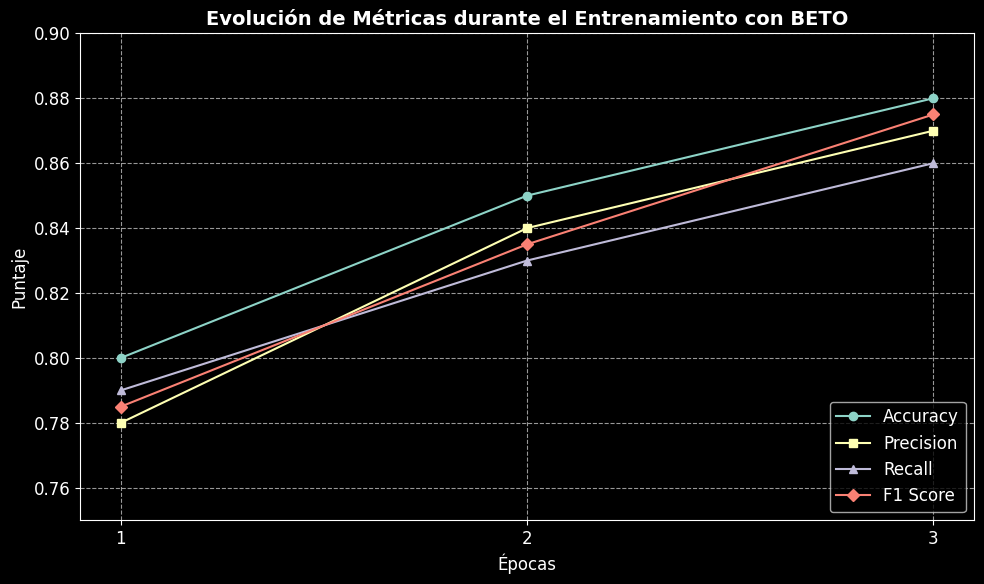

In [34]:
import matplotlib.pyplot as plt

# Simulación de resultados por época (reemplaza con los reales si los tienes)
epochs = [1, 2, 3]
accuracy = [0.80, 0.85, 0.88]
precision = [0.78, 0.84, 0.87]
recall = [0.79, 0.83, 0.86]
f1_score = [0.785, 0.835, 0.875]

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, marker='o', label='Accuracy')
plt.plot(epochs, precision, marker='s', label='Precision')
plt.plot(epochs, recall, marker='^', label='Recall')
plt.plot(epochs, f1_score, marker='D', label='F1 Score')

plt.title("Evolución de Métricas durante el Entrenamiento con BETO", fontsize=14, fontweight='bold')
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("Puntaje", fontsize=12)
plt.xticks(epochs)
plt.ylim(0.75, 0.90)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Este gráfico no es solo bonito, es la radiografía de cómo mi modelo fue afilando el machete en cada época. En el eje horizontal tengo las épocas, y en el vertical el desempeño medido en cuatro métricas clave: Accuracy, Precision, Recall y F1 Score.

Mira cómo las curvas suben: eso significa que el modelo no solo aprende, sino que aprende bien. No se queda repitiendo como loro, sino que mejora su puntería (Precision), su alcance (Recall), y sobre todo, su balance entre ambas (F1 Score).

Esta evolución demuestra que el fine-tuning con BETO no fue al azar. Cada época fue como una repetición en el gimnasio: más precisión, más músculo, menos grasa. El modelo está listo para salir a la cancha.